In [43]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

In [44]:
def prep_questions(qpath="data/questions-words.txt"):

    dquestions = {}
    with open(qpath, 'r') as fd:
        key = None
        tests = fd.read().lower().split('\n')
        rest = tests.pop()
        for test in tests:
            categ = test[0]
            if categ == ':':
                dquestions[test] = []
                key = test
            else:
                dquestions[key].append(test.split(' '))
    return dquestions

dqts = prep_questions()

# Reconstruindo os resultados

In [45]:
dscores = {}
for flog in os.listdir("outputs/models/"):
    with open(f"outputs/models/{flog}", 'r') as fd:
        dscores[flog.replace(".json",'')] = json.load(fd)

In [46]:
def get_params(key):
    
    tokens = key.split('_')
    wsize = int(tokens[1].split('-')[-1])
    vsize = int(tokens[3].split('-')[-1])
    sg = int(tokens[4].split('-')[-1])
    mcount = int(tokens[-1].split('-')[-1])

    return wsize, vsize, sg, mcount

rows = []
# Para cada modelo.
for key in dscores:
    wsize, vsize, sg, mcount = get_params(key)
    # para cada categoria no modelo.
    for categ in dscores[key]:
        try:
            hits = dscores[key][categ]["hits"]
            misses = dscores[key][categ]["misses"]
            close_to = dscores[key][categ]["close_to"]
            score = dscores[key][categ]["score"]
            rows.append([categ, vsize, wsize, sg, mcount, hits, misses, close_to, score])
        except:
            print(key)


In [47]:
cols = ['category', 'vector_size', 'window_size', 'sg', 'min_count', 'hits', 'misses', 'close_to', 'score']
df = pd.DataFrame(rows, columns=cols)
df.head()

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
0,: capital-common-countries,100,1,1,1,0,506,0,0.000000
1,: capital-world,100,1,1,1,0,4216,0,0.000000
2,: currency,100,1,1,1,0,866,0,0.000000
3,: city-in-state,100,1,1,1,0,2467,0,0.000000
4,: family,100,1,1,1,38,301,81,65.224211


In [48]:
def plot_distib(df, var_target, observed_vars=['hits', 'misses', 'score', 'close_to'], dqts=None):
    

    plt.figure(figsize=(25,5))
    plt.tight_layout()
    cont = 1
    flag_legend = True
    # Para cada variável de interesse.
    for tvar in observed_vars:
        max_value = 0
        lines = ["-","--","-.",":"]
        linecycler = cycle(lines)
        # Para cada categoria.
        for categ in set(df.category):
            # Filtrando o dataset por categoria.
            categ_df = df[df.category == categ].sort_values(by=[var_target])
            # Pegando os labels do eixo-x.
            x_labels = categ_df[var_target].values
            x = list(range(1, len(x_labels) + 1))
            y = categ_df[tvar].values / len(dqts[categ])
            plt.subplot(1,4, cont)
            plt.yticks(fontsize=14)
            if flag_legend:
                plt.plot(x, y, label=categ, linestyle=next(linecycler))
            else:
                plt.plot(x, y, linestyle=next(linecycler))
            plt.xticks(x, x_labels, fontsize=14)
        # Formatando os gráficos.
        plt.xticks(x, x_labels, fontsize=14, rotation=45)
        plt.xlabel(var_target, fontsize=14)
        yl = f"{tvar} (%)"
        if tvar == "score":
            yl = tvar
        plt.ylabel(yl, fontsize=14)
        plt.grid()
        cont += 1
        flag_legend = False
    plt.figlegend(ncol=3, loc="upper center", fontsize=16, bbox_to_anchor =(0.5, 1.35))#, borderpad=0.3)
    plt.tight_layout()

def plot_distib_average(df, var_target, observed_vars=['hits', 'misses', 'score', 'close_to']):
    
    plt.figure(figsize=(25,4))
    cont = 1
    flag_legend = True
    # Para cada variável de interesse.
    for tvar in observed_vars:
        # Calculando os valores médios.
        plt.subplot(1,4, cont)
        y = df.groupby(var_target).agg({tvar: "mean"}).sort_values(by=[var_target]).values
        y = y.reshape(y.shape[0])
        y_std = df.groupby(var_target).agg({tvar: "std"}).values
        y_std = y_std.reshape(y_std.shape[0])
        x_labels = df[df.category == df.category.iloc[0]].sort_values(by=[var_target])[var_target]
        x = list(range(1, len(x_labels) + 1))
        if flag_legend:
            plt.errorbar(x, y, y_std, label="Average", marker='o')
            flag_legend = False
        else:
            plt.errorbar(x, y, y_std, marker='o')
        # Formatando os gráficos.
        plt.xticks(x, x_labels, fontsize=14, rotation=45)
        plt.xlabel(var_target, fontsize=14)
        yl = f"{tvar} (%)"
        if tvar == "score":
            yl = tvar
        plt.ylabel(yl, fontsize=14)
        plt.grid()
        cont += 1
    plt.figlegend(ncol=4, loc="upper center", fontsize=16)

# Análise do tamanho da janela (window_size)

### Fixando os demais parâmetros para a análise. Dimensão dos vetores 100, Skip-Gram ativado, Frequência mínima das palavras 1.

In [49]:
window_df = df[(df.vector_size == 100) & (df.sg == 1) & (df.min_count == 1)]
window_df.head(5)

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
0,: capital-common-countries,100,1,1,1,0,506,0,0.000000
1,: capital-world,100,1,1,1,0,4216,0,0.000000
2,: currency,100,1,1,1,0,866,0,0.000000
3,: city-in-state,100,1,1,1,0,2467,0,0.000000
4,: family,100,1,1,1,38,301,81,65.224211


## Discusão impactos da variação do tamanho da janela (Window Size)

#### Legendas

* Gráfico 1: (eixo X) window_size x (eixo Y) porcentagem de acertos (hits)
* Gráfico 2: (eixo X) window_size x (eixo Y) porcentagem de erros (misses)
* Gráfico 3: (eixo X) window_size x (eixo Y) score normalizado (1/ri * si), para ri a posição da palavra esperada no ranking de palavras mais próximas e si a similaridade entre o vetor resultante e a palavra esperada.
* Gráfico 4: (eixo X) window_size x (eixo Y) quantidade de aparições da palavra esperada no ranking (close_to)

*** Todos os valores nos gráficos abaixo foram normalizados pela quantidade de testes de cada catetoria.

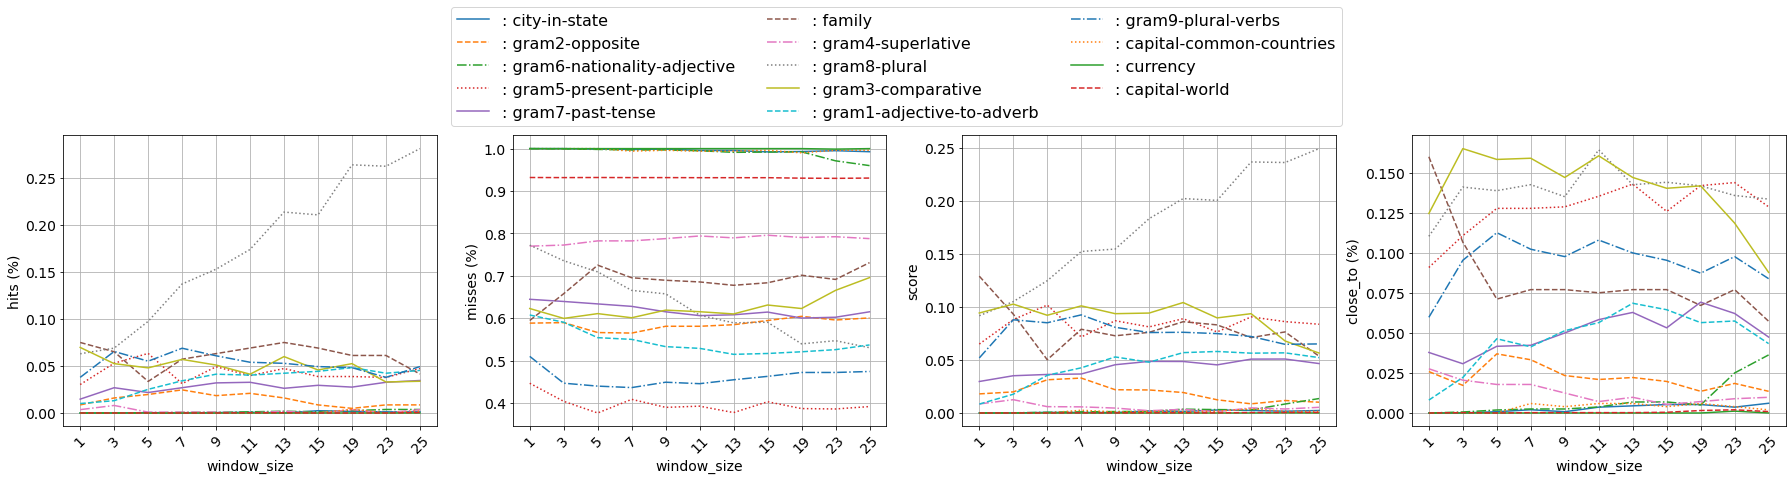

In [50]:
plot_distib(window_df, 'window_size', dqts=dqts)


No primeiro gráfico, temos o conjunto de todas o desempenho de todas as categorias variando o tamanho da janela utilizada no treinamento dos modelos. Visivelmente o aumento do tamanho da janela dos modelos não beneficiou o desempenho do mesmo em nenhuma categoria menos a gramar8-plural. Como podemos ver, para essa categoria a quantidade de hits (vezes em que a palavra mais próxima é a palavra esperada) ficou maio ruqe 25% dos testes para janelas de tamanho 19. Consequentemente o score (gráfico 3 também subiu), a quantidade de misses (vezes que a palavra não apareceu no ranking) caiud de ~78% para ~62% (16 pontos percentuais) e o score (inverso da posição da palavra no ranking pela similaridade de cosseno entre o vetor resultante e a palavra esperada) que aumentou significativamente, saindo de ~9.7 com a ganela de tamanho 1, indo para 25 com a janela de tamanho 25.

Devemos levar em consideração que, para a categoria gram8-plural aumentar o tamanho da janela é benéfico e provavelmente específico para esta categoria. Desta forma, para tarefas específicas relacionadas ao trabalho com plural, janelas maiores tendem a ter resultados melhores. Por outro lado, categorias como gram5-present-participle, gram6-nationality-adjective não foram influenciadas pela variação do tamanho da janela, de modo que os valores obtidos para tais categorias permaneceram praticamente constantes, com elevado número de misses 92,3%, ~100% para a segunda para todo tamanho de janela. Outra categoria que manteve baixos valores de hits constantes para quase todo os valores de janela foi a categoria currency. Como Podemos ver no gráfico 1, 2, ela teve ~0% de hits, ~100% de misses para janelas de tamanho menor que 20. Porém, para janela de tamanho 23 e 25 temos um leve aumento no score (gráfico 3) e no close_to, mostrando que a palavra esperada começa a surgir no ranking. Também podemos ver uma queda de aproximadamente %5 na quantidade de misses (gráfico 2).

Para as demais categorias, os modelos não mostraram tendências significativas, menos para a categoria gram3-comparative, que ao contrário das categorias a cima, apresenta ligeira queda na quantidade de hits, score e close_to, porém, análises mais específicas sobre essa categoria seriam necessárias para confirmar a tendência na da queda do desempenho conforme o aumento do tamanho da janela.

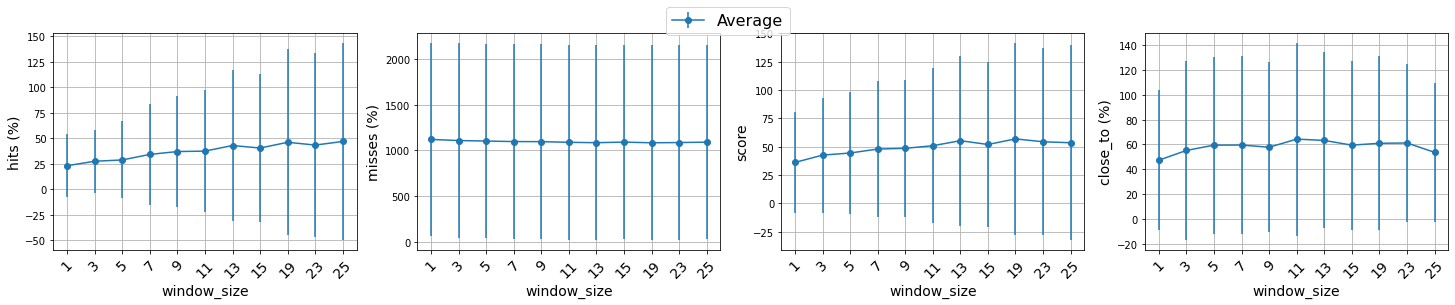

In [51]:
plot_distib_average(window_df, 'window_size')

No geral, não podemos inferir melhoras significativas no aumento ou redução do tamanho da janel, visto que os modelos não mostrarem uma tendência geral para categorias. No gráfico 1

# Analisando a dimensão do embedding (vector_size)

### Fixando os demais parâmetros para a análise. Tamanho da janela 5, Skip-Gram ativado, Frequência mínima das palavras 1.

In [52]:
vector_df = df[(df.window_size == 5) & (df.sg == 1) & (df.min_count == 1)]
vector_df.head(5)

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
56,: capital-common-countries,200,5,1,1,0,506,0,0.000000
57,: capital-world,200,5,1,1,0,4216,0,0.000000
58,: currency,200,5,1,1,0,866,0,0.000000
59,: city-in-state,200,5,1,1,0,2466,1,0.156486
60,: family,200,5,1,1,33,344,43,38.169100


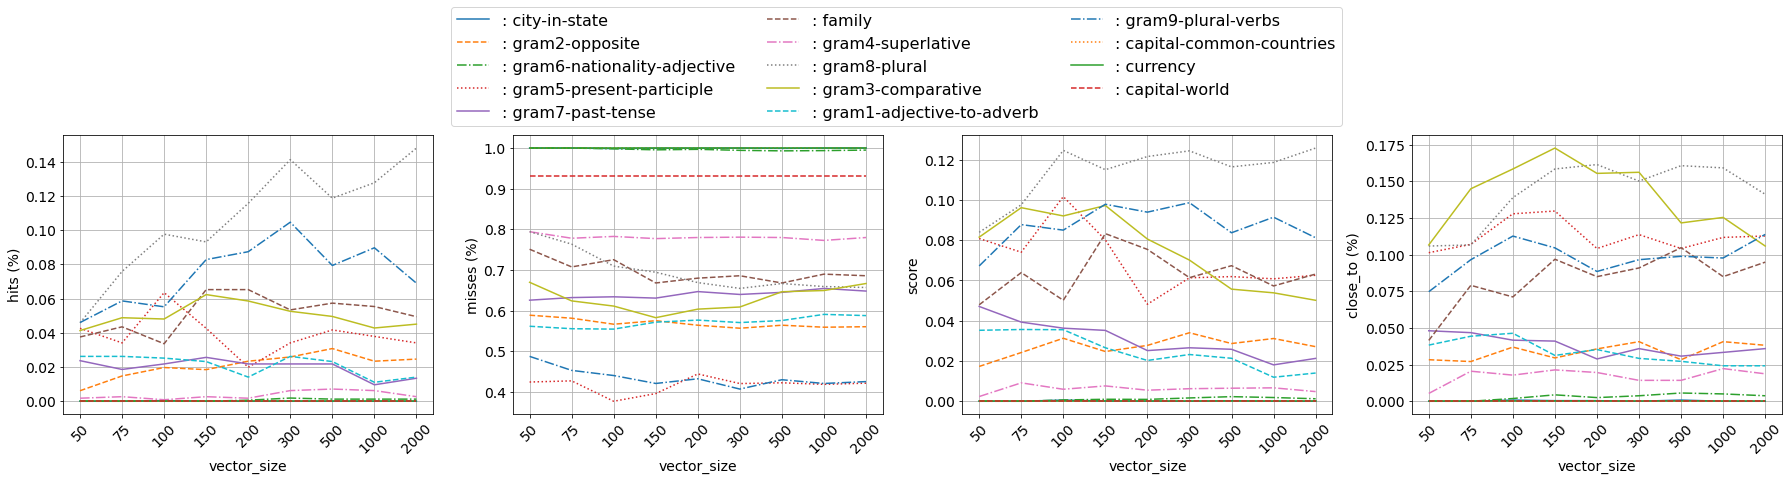

In [53]:
plot_distib(vector_df, 'vector_size', dqts=dqts)

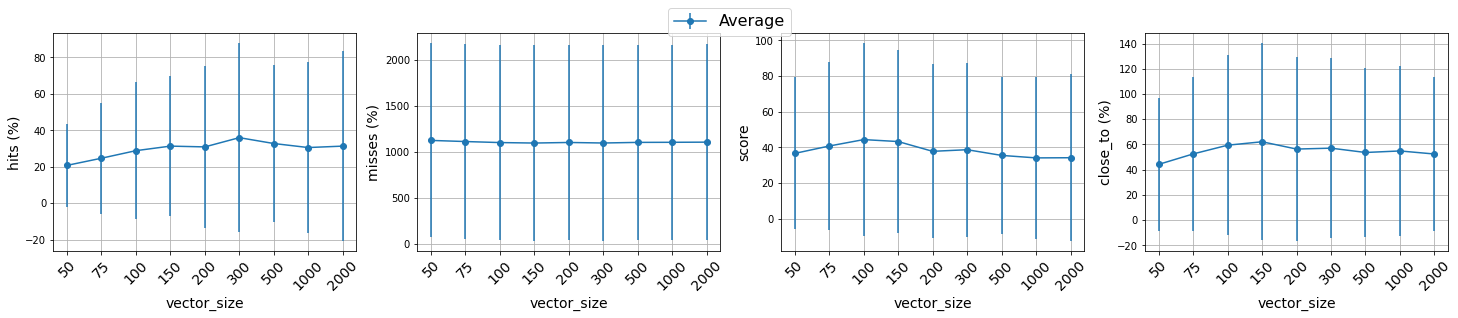

In [54]:
plot_distib_average(vector_df, 'vector_size')

# Comparando os modelos Skip-Gram e CBOW.

In [55]:
skip_cbow = df[(df.window_size == 5) & (df.vector_size == 100) & (df.min_count == 1)]
skip_cbow.head(5)

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
28,: capital-common-countries,100,5,0,1,0,506,0,0.000000
29,: capital-world,100,5,0,1,0,4214,2,0.357964
30,: currency,100,5,0,1,0,866,0,0.000000
31,: city-in-state,100,5,0,1,0,2463,4,1.707354
32,: family,100,5,0,1,16,370,34,23.920499


In [56]:
def identity(x):
    return x

tabs = []
for col in ["hits", "misses", "score", "close_to"]:
    t = pd.crosstab(skip_cbow.category, skip_cbow.sg, values=skip_cbow[col].values, aggfunc=identity)
    tabs.append(t)

In [57]:
table = pd.concat(tabs, axis=1)
table

sg,0,1,0,1,0,1,0,1
category,,,,,,,,
: capital-common-countries,0,0,506,506,0.000000,0.000000,0,0
: capital-world,0,0,4214,4216,0.357964,0.000000,2,0
: city-in-state,0,1,2463,2464,1.707354,1.429811,4,2
: currency,0,0,866,866,0.000000,0.000000,0,0
: family,16,17,370,367,23.920499,25.380842,34,36
: gram1-adjective-to-adverb,11,25,579,550,20.230288,35.254525,31,46
: gram2-opposite,1,16,503,460,1.712443,25.407169,2,30
: gram3-comparative,26,64,988,814,45.030943,122.622815,75,211
: gram4-superlative,0,1,896,878,0.521419,6.689974,3,20


In [58]:
agg = { m: "mean" for m in ['hits', 'misses', 'score', 'close_to'] }

g = skip_cbow.groupby(by="sg").agg(agg)
g

,hits,misses,score,close_to
sg,,,,
0,19.428571,1129.642857,33.266248,41.357143
1,28.785714,1102.285714,44.409421,59.357143


In [59]:
gt = g.T
gtr = gt.values.T.reshape(gt.shape[0] * 2)
pd.DataFrame(gtr).T

,0,1,2,3,4,5,6,7
0,19.428571,1129.642857,33.266248,41.357143,28.785714,1102.285714,44.409421,59.357143


# Avaliação da frequência mínima das palavras

In [60]:
min_count_df = df[(df.window_size == 5) & (df.vector_size == 100) & (df.sg == 1)]
min_count_df.head(5)

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
14,: capital-common-countries,100,5,1,5,0,505,1,0.213002
15,: capital-world,100,5,1,5,0,3563,1,0.213002
16,: currency,100,5,1,5,0,721,0,0.000000
17,: city-in-state,100,5,1,5,1,2327,2,1.092888
18,: family,100,5,1,5,21,311,29,25.240842


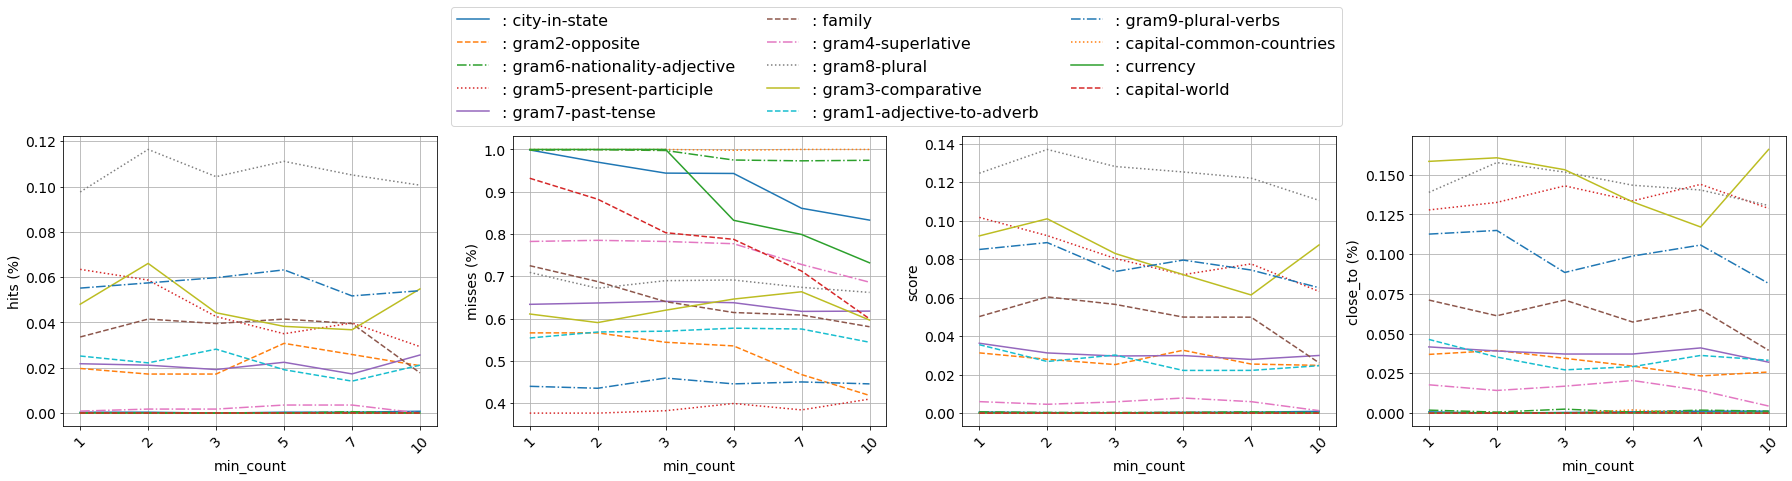

In [61]:
plot_distib(min_count_df, 'min_count', dqts=dqts)

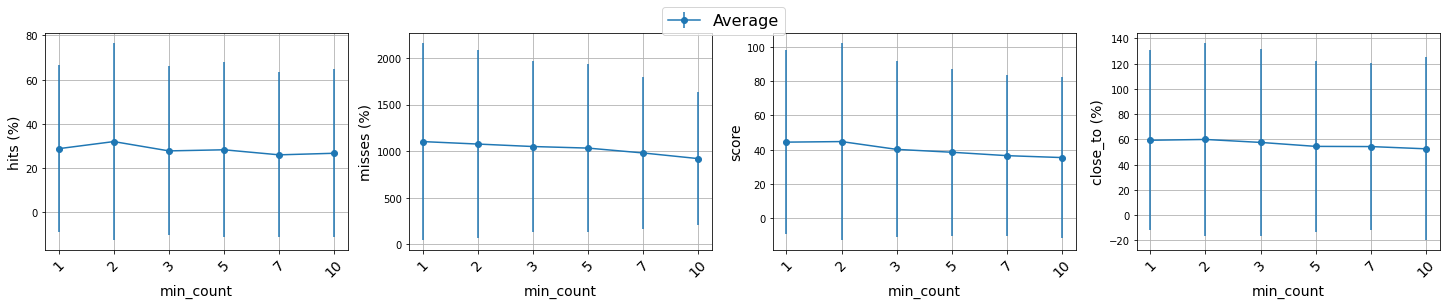

In [62]:
plot_distib_average(min_count_df, 'min_count')

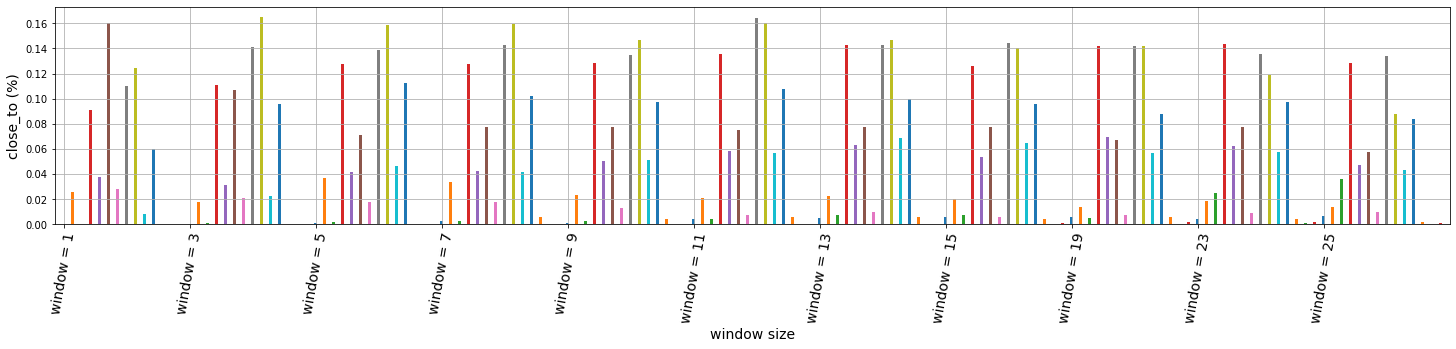

In [63]:
def get_x(begin, gap, len):

    values = []
    acc = begin
    for i in range(len):
        values.append(acc)
        acc += gap
    return np.array(values)
    
plt.figure(figsize=(25,4))
ax = plt.subplot(111)
begin = 0
categs = set(window_df.category)
gap = len(categs)
graph_len = len(set(window_df.window_size))
# Para cada categoria.
for categ in categs:
    categ_df = window_df[window_df.category == categ ]
    # Para cada tamanho de janela.
    y = []
    wds = sorted(set(categ_df.window_size))
    for wd in wds:
        wd_df = categ_df[categ_df.window_size == wd]
        y.append(wd_df["close_to"].iloc[0])
    y = np.array(y) / len(dqts[categ])
    x = get_x(begin, gap, graph_len)
    ax.bar(x, y, width=0.4, align="center")
    # Se for a primeira categoria.
    if begin == 0:
        wds_labels = [ f"window = {v}" for v in wds ]
        ax.set_xticks(x, labels=wds_labels, rotation=80, fontsize=14)
    begin += 1

ax.set_xlabel("window size", fontsize=14)
ax.set_ylabel(f"close_to (%)", fontsize=14)
ax.set_xlim([-1, gap * graph_len])
ax.grid()